# Causal Effect Inference

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

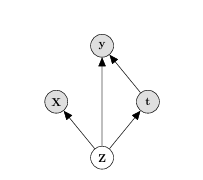

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

In [1]:
from data_gen import synthetic_dataset_pyro
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch

/home/giovanni/Desktop/pml_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = synthetic_dataset_pyro(n=2000, beta=2.0, num_proxies=10,prior_type = "gaussian", seed=42)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [3]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,1.0,3.374198,1.926915,1.963458,-0.688857,-1.794350,0.164417,-1.106328,0.477889,-0.949815,-1.100642,-0.573700,1.335683,-0.812672
1,0.0,0.389723,1.487284,1.743642,-0.803419,-0.667056,-0.221031,-0.335255,-2.074355,-0.946630,-0.484487,0.730178,-0.984199,0.626180
2,1.0,2.342756,0.900717,1.450359,-0.960594,0.498550,-0.208753,0.067716,0.217839,-0.090666,0.945358,0.879692,-1.900329,-1.909228
3,0.0,-3.112403,-2.105521,-0.052760,0.131827,1.523604,-1.069372,0.534380,-0.513794,2.163477,0.522745,-2.856230,-0.540974,0.486115
4,1.0,2.221629,0.678418,1.339209,0.114251,-1.388160,-0.912516,0.000940,1.237285,-0.903159,-1.597616,-1.240581,0.409051,-0.279541


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [4]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.6441078


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [5]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

In [6]:
# this doesn't work in all python enviroments, for reference look at the generated image
#model.view_model(file_name="causal_model_no_hidden_confounder")

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4,U) = P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

For this purpose, we estimate the ATE using the linear regression to approximate the conditional probability $p(y|x,t)$.

In [8]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4,U) = P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4)

## Realized estimand
b: y~t+x_7+x_6+x_0+x_1+x_9+x_2+x_3+x_8+x_5+x_4
Target units: ate

## Estimate
Mean value: 1.826061380209927
p-value: [7.30073984e-131]



We estimated that receiving the treatment (t=1) increases the outcome of $1.826$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

Other types of estimation are possible, we try a couple more.

In [9]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching", test_significance=True
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4,U) = P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4)

## Realized estimand
b: y~t+x_7+x_6+x_0+x_1+x_9+x_2+x_3+x_8+x_5+x_4
Target units: ate

## Estimate
Mean value: 1.6661792807467282
p-value: [0, 0.001]



In [10]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4,U) = P(y|t,x_7,x_6,x_0,x_1,x_9,x_2,x_3,x_8,x_5,x_4)

## Realized estimand
b: y~t+x_7+x_6+x_0+x_1+x_9+x_2+x_3+x_8+x_5+x_4
Target units: ate

## Estimate
Mean value: 1.727517274860689
p-value: [0, 0.001]



With different estimation methods we have obtained the following results:
- $1.82$ with linear regression
- $1.66$  with propensity score matching
- $1.72$ with propensity score weighting

**Remark**: I also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.


In [ ]:
cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=5,
    hidden_dim=300
    )

In [ ]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

length_x  = x.shape[1]

In [13]:
print("x.shape:", x.shape)       # should be (N, D)
print("cevae.feature_dim:", cevae.feature_dim)


x.shape: torch.Size([2000, 10])
cevae.feature_dim: 10


In [14]:
losses = cevae.fit(
    x, t, y,
    num_epochs=500,
    batch_size=128,
    learning_rate=5e-4,
    learning_rate_decay=0.1,
    weight_decay=1e-5
    )

INFO 	 Training with 16 minibatches per epoch


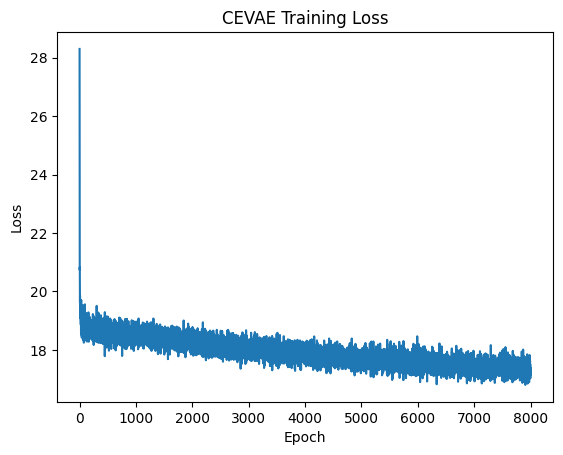

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

In [18]:
# Estimate ITEs and ATE
ite = cevae.ite(x)
ate = ite.mean().item()

# Compare
print(f"Estimated ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

INFO 	 Evaluating 1 minibatches


Estimated ATE: 1.4226
True ATE: 1.0008
